In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import copy as cp
import pandas as pd
import countryinfo
import geopandas as gpd
from timeit import default_timer as timer # try to measure time
from climada.engine import Impact
from os import mkdir, remove, rmdir


In [2]:
##function definition
from functions import *
from climada_functions import *
from constants import * 

In [3]:
print(cmip6vars)

{'sfcWindmax': 'SWM', 'sfcWind': 'SW', 'psl': 'SLP', 'tas': 'TAS', 'ua': 'UA', 'ta': 'TA', 'tos': 'TOS'}


In [3]:
## select data
#select variable (cmip6 naming)
selvar = 'sfcWindmax'
pathinvar = pathcmip6+'sfcWindmax/'

#preprocessing 
gst_fact = 1.67
qt = 0.98
cut=2E6
min_lat=30
max_lat=75
min_lon=-30
max_lon=30

##climada constants
haz_type = 'WS'
haz_id = 1

## naming
#name base (meteo) variable
metvar = [cmip6vars[selvar]]
spaceres = ["br_rg"] #base resolution regridded
timeres = ["day"]
domain = ["EU"]
season = ["winE"]
scen = ["allscens"]
sep = "_"
lst_bn = metvar+spaceres+timeres+domain+season+scen
basenamemet = sep.join(lst_bn)

#preproc field
processings = ["qt"+str(qt)[-2:]+"pst","cutarea"+format(cut,'.0E').replace("+0",''),"gst1-67"]
basenamemet_proc = make_fn(processings,basenamemet)

#dic to map each impact func to its preprocessing function
pp_func_dic = {'Cubic excess-over-threshold':scale_qt,'Emanuel 2011':mask_qt,'Welker 2021':mask_qt}

In [16]:
#cell to test ncdf imports and preprocess
modname = 'ACCESS-ESM1-5'
#fn = pathinvar+modname+'_'+basenamemet+".nc"
fn = make_fn([modname],basenamemet,filetype=".nc")
ncdf1 = xr.open_dataset(pathinvar+fn)
ncdf_past = ncdf1['historical']
ncdf_qt = ncdf_past.quantile(qt,dim=("day","member"))
haz = set_centroids(ncdf_past,timeres="day")
#haz.plot_rp_intensity(smooth=False)

<GeoAxesSubplot:title={'center':'WS max intensity at each point'}>

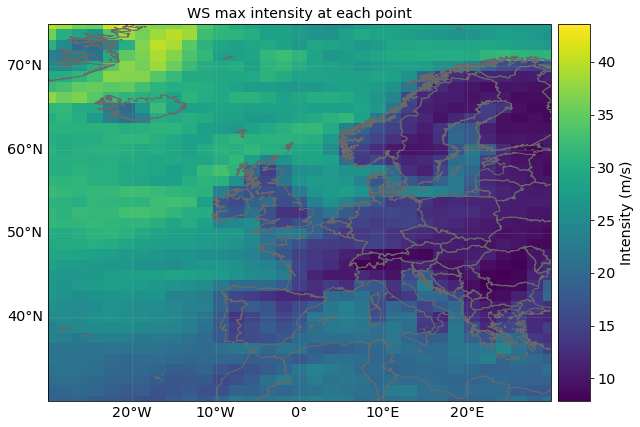

In [18]:
haz.plot_intensity(event=0,smooth=False)

# Exposure

In [4]:
#import exposure data (already preprocessed)
from climada.entity import Exposures
from climada import CONFIG
results = CONFIG.local_data.save_dir.dir()
exp = Exposures.from_hdf5(results.joinpath(('exposures/exp_crpd_EU_600.h5')))
exp.check()


/home/lseverino/.conda/envs/climada_env/lib/python3.8/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)


Text(0.5, 1.0, 'LitPop Exposure for Europe, 2018\nProduced capital')

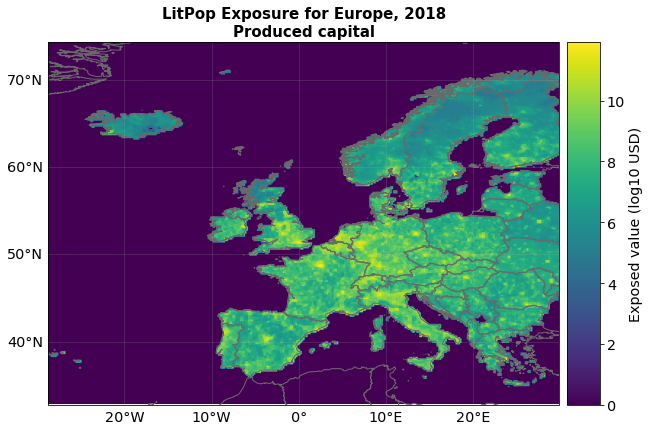

In [6]:
#ax = exp.plot_hexbin(pop_name=False,vmin=1E7,vmax=1E11
ax = exp.plot_raster(label='Exposed value (log10 USD)')

ax.set_title('LitPop Exposure for Europe, 2018\nProduced capital',fontsize=15,fontweight="bold")
#plt.savefig(savefigpath+'/Exposures/hexbin_exp_cropped600EU.png',transparent=False)

# Impact functions

In [5]:
# Implement impact function cubic excess from Prahl 2015 
from climada.entity import ImpactFunc
imp_fun = ImpactFunc()
imp_fun.haz_type = 'WS'
imp_fun.id = 0
imp_fun.name = 'Cubic excess-over-threshold'
# provide unit of the hazard intensity
imp_fun.intensity_unit = 'm/s'
# provide values for the hazard intensity, mdd, and paa
#imp_fun.intensity = np.linspace(0, 100, num=1500)
#mdd = imp_fun.intensity**3
#mdd_capped = np.where(mdd>1,1,mdd)
#imp_fun.mdd = mdd_capped
imp_fun.intensity = np.linspace(0, 1, num=20)
imp_fun.mdd = imp_fun.intensity**3
imp_fun.intensity = np.append(imp_fun.intensity, [100])
imp_fun.mdd = np.append(imp_fun.mdd, [1])
imp_fun.paa = np.ones(imp_fun.intensity.shape)
# check if the all the attributes are set correctly
imp_fun.check()


2022-05-30 13:11:48,285 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.


In [6]:
## impact function
from climada.entity.impact_funcs import storm_europe, ImpfTropCyclone

# Here we generate the impact function for TC damage using the formula of Emanuel 2011
impFunc_welker = storm_europe.ImpfStormEurope.from_welker()
impFunc_emanuel_usa = ImpfTropCyclone.from_emanuel_usa()

# plot the impact function
impFunc_emanuel_usa.id = 0
impFunc_emanuel_usa.haz_type = 'WS'
impFunc_emanuel_usa.check()

impFunc_welker.id = 0
impFunc_welker.haz_type = 'WS'
impFunc_welker.check()

2022-05-30 13:11:48,321 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.


2022-05-30 13:11:48,338 - climada.entity.impact_funcs.impact_func_set - WARNING - Input ImpactFunc's id not set.
2022-05-30 13:11:48,341 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-05-30 13:11:48,488 - climada.entity.impact_funcs.impact_func_set - WARNING - Input ImpactFunc's id not set.
2022-05-30 13:11:48,492 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-05-30 13:11:48,550 - climada.entity.impact_funcs.impact_func_set - WARNING - Input ImpactFunc's id not set.


(0.0, 2.0)

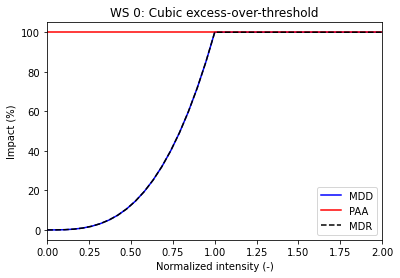

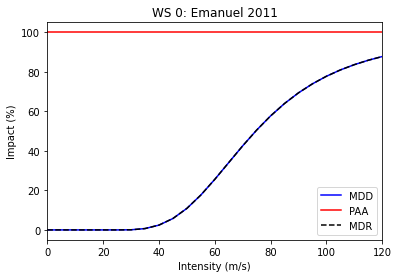

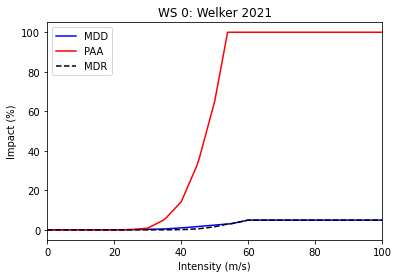

In [7]:
# generate 1 impf set per impact function 
from climada.entity import ImpactFuncSet
impf_list = [imp_fun,impFunc_emanuel_usa,impFunc_welker]
impf_namelist = []
impf_dict = dict()
axs=[]
for impf in impf_list:
    impfname = impf.name
    impf_namelist.append(impfname)
    impf_set = ImpactFuncSet()
    impf_set.append(impf)
    impf_set.check()
    ax = impf_set.plot()
    axs.append(ax)
    #plt.ylim((0,105))
    #plt.xlim((0,1))

    impf_dict[impfname] = impf_set
axs[0].set_xlabel('Normalized intensity (-)')
axs[0].set_xlim((0,2))

In [8]:
#dic to map each impact func to its preprocessing function
pp_func_dic = {'Cubic excess-over-threshold':scale_qt,'Emanuel 2011':mask_qt,'Welker 2021':mask_qt}

/tmp/ipykernel_38386/1297472793.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


Text(0, 0.5, 'Impact (%)')

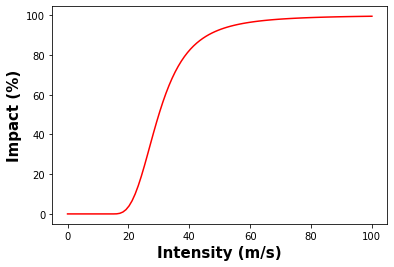

In [12]:
intensity = np.linspace(0,100,num=100)
vhalf = 30
vthresh  = 15
v = intensity-vthresh
vn = np.where(v>=0,v,0)/(vhalf-vthresh)
mdd = vn**3/(1+vn**3)
fig = plt.figure()
ax = fig.subplots(1,1)
ax.plot(intensity,mdd,color='red')
labels=[0 ,0 ,20,40,60,80,100]
ax.set_yticklabels(labels)
ax.set_xlabel('Intensity (m/s)',fontsize=15,fontweight='bold')
ax.set_ylabel('Impact (%)',fontsize=15,fontweight='bold')

# Main calculation cell
Use stack=True to stack model members on top of each other, set stack=False to consider each member separately.
Use savehaz, saveimpcsv, saveimpmat to save hazards or/and imapcts.
1) Loop over impact functions
2) Loop over scenarios
3) Loop over climate models
4) Loop over model members


In [9]:
impf_namelist

['Cubic excess-over-threshold', 'Emanuel 2011', 'Welker 2021']

In [10]:
scenlist

['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']

In [11]:
#select climate models, used scenarios (historical, ssp585,...), impact functions and calibration type
modlist = modlist_allscen[:2]
impf_used = ['Welker 2021']
scen_used= ["historical","ssp585"]
pastname = 'historical'
timeres='day'
nmems = 3
caltype = 'AAI_EMDAT'

In [12]:
#initiate df to save results
metrics = ["AAI_agg","45 yr impact","90 yr impact"]
itercol = [scenlist,metrics]
col_idx = pd.MultiIndex.from_product(itercol,names=["scenario","metric"])
iterrows = [modlist,range(nmems)]
row_idx= pd.MultiIndex.from_product(iterrows,names=["model","member"])


In [14]:
##main calculation cell.
#Loop over impact functions, scenarios, models and model members
#Use stack=True to stack model members on top of each other, set stack=False to consider each member separately.
#Use savehaz, saveimpcsv, saveimpmat to save hazards or/and imapcts.
stack = True
savehaz = True
saveimpmat = True
saveimpcsv = True
savestats = False
if_id = 0
df_list = []
impf_keys = []
for impf in impf_used:
    #initiate df
    if stack:
        res_df = pd.DataFrame(columns=col_idx,index=modlist)
        nmems=1
    else:
        res_df = pd.DataFrame(columns=col_idx,index=row_idx)
    
    # get impfset
    impf_set = impf_dict[impf]
    
    # get names
    impf_namesht = impf_sht_names[impf]
    pp_funcname = str(pp_func_dic[impf]).split(" ")[1]
    savenamehaz = make_fn([pp_funcname],basenamemet_proc)
    savenameimp = make_fn([impf_namesht,caltype],basenamemet_proc)

    for scen in scen_used:
        for modid, modname in enumerate(modlist):    
            #read netcdf
            fn = make_fn([modname],basenamemet,filetype=".nc")
            ncdf = xr.open_dataset(pathinvar+fn)
            ncdfw = ncdf[[pastname,scen]]
            #apply gust factor
            gust_ds = gst_fact*ncdfw
            nmems = len(gust_ds['member'])
            
            #calibrate impf
            if caltype!='nocal':
                calname = make_fn(["cal",caltype],basenamemet_proc,filetype=".csv")
                paramspath = pathcal+calname
                param = pd.read_csv(paramspath,header=[0,1,2],index_col=0).loc[modname,(impf_namesht,"historical","AAI_agg")]
                impf_set = tune_impf(impf_set,param,modname,plot=False)
                if_id = 1 #select calibrated impf (1 for calibrated impf, 0 otherwise)
            

            #iterate over the members
            for nmem in range(nmems):
                
                #preprocess fields
                if stack:
                    mem_da = gust_ds
                else: 
                    mem_da = gust_ds.sel(member=nmem)
            
                preprocess_func = pp_func_dic[impf]
            
                gust_pp = preprocess_func(mem_da,qt,cutarea=cut,timeres=timeres,pastname=pastname,futname=scen,stack=stack)
                gust_pp_sel = gust_pp[scen]
                
                #prepare hazards centroids
                haz = set_centroids(gust_pp_sel,stack=stack,timeres=timeres,plot=False)
                if impf_namesht == 'CubEOT':
                    max_int =  haz.intensity.max()
                    if max_int >= 1:
                        print("*"*100+'\n\n'+' '*25+'/!\ max_int = '+str(max_int)+' for model '+modname+'\n\n'+"*"*100)
                
                
                # deepcopy exposure before assigning centroids
                exp_sel = cp.deepcopy(exp)
                # Exposures: rename column and assign id
                exp_sel.gdf.rename(columns={"impf_": "impf_" + haz_type}, inplace=True)
                exp_sel.gdf['impf_' + haz_type] = if_id

                #assign centroids
                exp_sel.assign_centroids(haz,distance='euclidian',threshold=100)
                exp_sel.check()
                
                #compute impacts
                #past
                start_time = timer()
                imp = Impact()
                imp.calc(exp_sel, impf_set, haz, save_mat=saveimpmat) #Do not save the results geographically resolved (only aggregate values)
                time_delta_past = timer() - start_time
                print(time_delta_past)
    
                #save results
                if savestats:
                    #compute freq curves 
                    imp45 = imp.calc_freq_curve(return_per=45).impact 
                    imp90 = imp.calc_freq_curve(return_per=90).impact 
                    if stack:
                        res_df.loc[modname,(scen,"AAI_agg")] = imp.aai_agg
                        res_df.loc[modname,(scen,"45 yr impact")] = imp45
                        res_df.loc[modname,(scen,"90 yr impact")] = imp90
                    else: 
                        res_df.loc[(modname,nmem),(scen,"AAI_agg")] = imp.aai_agg
                        res_df.loc[(modname,nmem),(scen,"45 yr impact")] = imp45
                        res_df.loc[(modname,nmem),(scen,"90 yr impact")] = imp90
                
                ##save files
                
                if stack:
                    simname = 'stacked'
                    savesubdir = 'stacked/'+scen+'/'
                else:
                    simname = 'nmem'+str(nmem)
                    savesubdir = 'memsep/'+scen+'/'

                
                #save hazards
                if savehaz:
                    try:
                        haz.write_hdf5(pathhaz+savesubdir+make_fn(['haz',simname,scen,modname],savenamehaz,filetype='.h5'))
                    except FileNotFoundError:
                        mkdir(pathhaz+savesubdir)
                        haz.write_hdf5(pathhaz+savesubdir+make_fn(['haz',simname,scen,modname],savenamehaz,filetype='.h5'))
                #save impacts
                if saveimpcsv:
                    try:
                        #rmdir(pathimp+'impact csv/memsep/'+scen+"/")
                        #mkdir(pathimp+'impact csv/memsep/'+scen+"/")
                        imp.write_csv(pathimp+'impact csv/aggregated/'+savesubdir+make_fn(['imp',simname,scen,modname],savenameimp,filetype='.csv'))
                    except FileNotFoundError:
                        mkdir(pathimp+'impact csv/aggregated/'+savesubdir)
                        imp.write_csv(pathimp+'impact csv/aggregated/'+savesubdir+make_fn(['imp',simname,scen,modname],savenameimp,filetype='.csv'))
                if saveimpmat:
                    try:
                        #rmdir(pathimp+'impact matrices/'+savesubdir)
                        #mkdir(pathimp+'impact matrices/'+savesubdir)
                        imp.write_sparse_csr(pathimp+'impact matrices/aggregated/'+savesubdir+make_fn(['imp',simname,scen,modname],savenameimp,filetype='.npz'))
                    except FileNotFoundError:
                        mkdir(pathimp+'impact matrices/aggregated/'+savesubdir)
                        imp.write_sparse_csr(pathimp+'impact matrices/aggregated/'+savesubdir+make_fn(['imp',simname,scen,modname],savenameimp,filetype='.npz'))
                
                #delete haz, imp and ep  objects
                del haz
                del imp
                del exp_sel
    res_df = res_df.astype(np.float64)
    impf_keys.append(impf_namesht)
    df_list.append(res_df)

res_df_all = pd.concat(df_list,keys=impf_keys,axis=1,names=("Impf","scenario","metric"))

ValueError: Coordinate assignment with "euclidian" distance is not supported.